<a href="https://colab.research.google.com/github/EiffL/AstroHackWeek2019/blob/master/day4_ml/photoz_inference_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Photoz with TensorFlow Probability - Part I: Data Preparation

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

In this series of tutorials, we learn how to combine Keras, TensorFlow Probability, and Google Colab to train a photo-z inference in the cloud. This first notebook in the series focuses on data preparation.

### Learning objectives

In this notebook, we will learn how to:
*   Setup a Google Cloud Bucket to store training data
*   Query the HSC Survey public data release with [unagi](https://github.com/dr-guangtou/unagi)
*   Export a dataset in TFRecord format.

### Imports

In [0]:
!pip install git+https://github.com/eiffl/unagi.git
import h5py
import six
import os
from astropy.table import Table
import astropy.units as u
from unagi import hsc
from unagi import task

  Cloning https://github.com/eiffl/unagi.git to /tmp/pip-req-build-4k6n46_0
  Running command git clone -q https://github.com/eiffl/unagi.git /tmp/pip-req-build-4k6n46_0
  Created wheel for unagi: filename=unagi-0.1.0-cp36-none-any.whl size=4175837 sha256=e6236858626946b902ee7a042f34d9f5addb7a5c7dd77e62b16f7faf35bce02f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gzn802xp/wheels/4c/39/e2/3565a57b9e302f5ea63c4e9680cbfab8f868256bc659c94532
Successfully built unagi


## Setting up a Google Cloud Bucket


In [0]:
from google.colab import auth
auth.authenticate_user()

bucket_name='ahw2019'

## Downloading data from the HSC Survey

Need an account on HSC


In [0]:
query = '''
-- Merge forced photometry and spectroscopic sample from HSC PDR 2 wide
SELECT object_id, ra, dec, tract, patch,
	-- Absorption
	a_g, a_r, a_i, a_z, a_y,
	-- Extendedness
	g_extendedness_value, r_extendedness_value, i_extendedness_value, z_extendedness_value, y_extendedness_value,
  -- Background Information
  g_localbackground_flux, r_localbackground_flux, i_localbackground_flux, z_localbackground_flux, y_localbackground_flux,
	-- Fluxes
	g_cmodel_flux, g_cmodel_fluxsigma, g_cmodel_exp_flux, g_cmodel_exp_fluxsigma, g_cmodel_dev_flux, g_cmodel_dev_fluxsigma,
	r_cmodel_flux, r_cmodel_fluxsigma, r_cmodel_exp_flux, r_cmodel_exp_fluxsigma, r_cmodel_dev_flux, r_cmodel_dev_fluxsigma,
	i_cmodel_flux, i_cmodel_fluxsigma, i_cmodel_exp_flux, i_cmodel_exp_fluxsigma, i_cmodel_dev_flux, i_cmodel_dev_fluxsigma,
	z_cmodel_flux, z_cmodel_fluxsigma, z_cmodel_exp_flux, z_cmodel_exp_fluxsigma, z_cmodel_dev_flux, z_cmodel_dev_fluxsigma,
	y_cmodel_flux, y_cmodel_fluxsigma, y_cmodel_exp_flux, y_cmodel_exp_fluxsigma, y_cmodel_dev_flux, y_cmodel_dev_fluxsigma,
	-- Magnitudes
	g_cmodel_mag, g_cmodel_magsigma, g_cmodel_exp_mag, g_cmodel_exp_magsigma, g_cmodel_dev_mag, g_cmodel_dev_magsigma,
	r_cmodel_mag, r_cmodel_magsigma, r_cmodel_exp_mag, r_cmodel_exp_magsigma, r_cmodel_dev_mag, r_cmodel_dev_magsigma,
	i_cmodel_mag, i_cmodel_magsigma, i_cmodel_exp_mag, i_cmodel_exp_magsigma, i_cmodel_dev_mag, i_cmodel_dev_magsigma,
	z_cmodel_mag, z_cmodel_magsigma, z_cmodel_exp_mag, z_cmodel_exp_magsigma, z_cmodel_dev_mag, z_cmodel_dev_magsigma,
	y_cmodel_mag, y_cmodel_magsigma, y_cmodel_exp_mag, y_cmodel_exp_magsigma, y_cmodel_dev_mag, y_cmodel_dev_magsigma,
	-- Shapes
	g_sdssshape_shape11, g_sdssshape_shape12, g_sdssshape_shape22, g_sdssshape_psf_shape11, g_sdssshape_psf_shape12, g_sdssshape_psf_shape22,
	r_sdssshape_shape11, r_sdssshape_shape12, r_sdssshape_shape22, r_sdssshape_psf_shape11, r_sdssshape_psf_shape12, r_sdssshape_psf_shape22,
	i_sdssshape_shape11, i_sdssshape_shape12, i_sdssshape_shape22, i_sdssshape_psf_shape11, i_sdssshape_psf_shape12, i_sdssshape_psf_shape22,
	z_sdssshape_shape11, z_sdssshape_shape12, z_sdssshape_shape22, z_sdssshape_psf_shape11, z_sdssshape_psf_shape12, z_sdssshape_psf_shape22,
	y_sdssshape_shape11, y_sdssshape_shape12, y_sdssshape_shape22, y_sdssshape_psf_shape11, y_sdssshape_psf_shape12, y_sdssshape_psf_shape22,
	-- specz
	d_pos, d_mag, specz_ra, specz_dec, specz_redshift, specz_redshift_err, specz_mag_i

FROM pdr2_wide.forced forced
  LEFT JOIN pdr2_wide.forced2 USING (object_id)
  LEFT JOIN pdr2_wide.forced3 USING (object_id)
	INNER JOIN pdr2_wide.specz USING (object_id)

-- Applying some data quality cuts
WHERE forced.isprimary
-- Keep only objects with reliable spectroscopic redshifts
AND specz.specz_flag_homogeneous
-- no stars, quasars, or failures
AND specz.specz_redshift < 9 AND specz.specz_redshift > 0.01
-- error cut
AND specz.specz_redshift_err < 0.005*(1 + specz.specz_redshift)
-- Keeping only the matches that fall within 0.2 arcsec
AND specz.d_pos <= 0.2
-- Simple Full Depth Full Colour cuts: At least 3 exposures in each band
AND forced.g_inputcount_value >= 3
AND forced.r_inputcount_value >= 3
AND forced.i_inputcount_value >= 3
AND forced.z_inputcount_value >= 3
AND forced.y_inputcount_value >= 3
-- Remove objects affected by bright stars
AND NOT forced.g_pixelflags_bright_objectcenter
AND NOT forced.r_pixelflags_bright_objectcenter
AND NOT forced.i_pixelflags_bright_objectcenter
AND NOT forced.z_pixelflags_bright_objectcenter
AND NOT forced.y_pixelflags_bright_objectcenter
AND NOT forced.g_pixelflags_bright_object
AND NOT forced.r_pixelflags_bright_object
AND NOT forced.i_pixelflags_bright_object
AND NOT forced.z_pixelflags_bright_object
AND NOT forced.y_pixelflags_bright_object
-- Remove objects intersecting edges
AND NOT forced.g_pixelflags_edge
AND NOT forced.r_pixelflags_edge
AND NOT forced.i_pixelflags_edge
AND NOT forced.z_pixelflags_edge
AND NOT forced.y_pixelflags_edge
-- Remove objects with saturated or interpolated pixels
AND NOT forced.g_pixelflags_saturatedcenter
AND NOT forced.r_pixelflags_saturatedcenter
AND NOT forced.i_pixelflags_saturatedcenter
AND NOT forced.z_pixelflags_saturatedcenter
AND NOT forced.y_pixelflags_saturatedcenter
AND NOT forced.g_pixelflags_interpolatedcenter
AND NOT forced.r_pixelflags_interpolatedcenter
AND NOT forced.i_pixelflags_interpolatedcenter
AND NOT forced.z_pixelflags_interpolatedcenter
AND NOT forced.y_pixelflags_interpolatedcenter
AND NOT forced.g_pixelflags_bad
AND NOT forced.r_pixelflags_bad
AND NOT forced.i_pixelflags_bad
AND NOT forced.z_pixelflags_bad
AND NOT forced.y_pixelflags_bad
-- Remove objects with generic cmodel fit failures
AND NOT forced.g_cmodel_flag
AND NOT forced.r_cmodel_flag
AND NOT forced.i_cmodel_flag
AND NOT forced.z_cmodel_flag
AND NOT forced.y_cmodel_flag
-- Sort by tract and patch for faster cutout query
ORDER BY object_id
;
'''

### Download catalog

In [0]:
# Login
archive = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

In [0]:
catalog = archive.sql_query(query, from_file=False, verbose=True)

In [0]:
# Save the catalog
catalog.write('catalog.fits')

Populating the interactive namespace from numpy and matplotlib


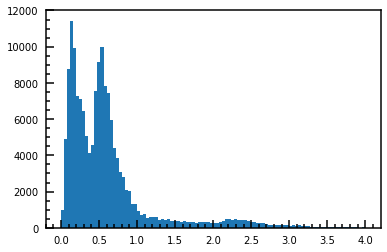

In [0]:
#  Let's check out the redshift distribution
%pylab inline
plt.rc('text', usetex=False) # Override latex setting set by unagi
hist(catalog['specz_redshift'], 100,range=[0,4]);

In [0]:
!gsutil cp catalog.fits gs://{bucket_name}/hsc_photoz/data/catalog.fits catalog.fits

### Download postage stamps cutouts

In [0]:
img_len = 64 # Size of cutouts in pixels
cutout_size = 0.168*(img_len + 2.5) # Size of cutouts in Arcsecs, with some additional margin
filters = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']

tmp_dir='tmp_dir'
out_dir='./'

!mkdir -p tmp_dir

In [0]:
cutouts_filename = task.hsc_bulk_cutout(catalog[0:1000], 
                                        cutout_size=cutout_size* u.Unit('arcsec'), 
                                        filters=filters, 
                                        archive=archive,  
                                        nproc=2, 
                                        tmp_dir=tmp_dir, 
                                        output_dir=out_dir)

Starting download of 1 batches ...
Download filter HSC-I for batch 0


Download finalized, aggregating cutouts.
CPU times: user 2.17 s, sys: 556 ms, total: 2.72 s
Wall time: 14min 10s


In [0]:
# Export the cutout file
!gsutil cp cutouts.hdf gs://{bucket_name}/hsc_photoz/data/cutouts.hdf cutouts.hdf

## Store dataset in TFRecords format


When dealing with large dataset and/or distributed computed, it quickly becomes 
complicated and inefficient to handle data...

In this section, we export training and testing sets for the model stored in TFrecords format


In [0]:
# Retrieve from the cloud the catalog and cutout file
import tensorflow as tf
tf.enable_eager_execution()

# If the instance is  clean, re-download data from cloud
if not os.path.isfile('catalog.fits'):
  !gsutil cp gs://{bucket_name}/hsc_photoz/data/catalog.fits catalog.fits
  print('Catalog download complete')

# This is the cutout file
if not os.path.isfile('cutouts.hdf'):
  !gsutil cp gs://{bucket_name}/hsc_photoz/data/cutouts.hdf cutouts.hdf
  print('Cutouts download complete')

# Loading the data
catalog = Table.read('catalog.fits')
cutouts = h5py.File('cutouts.hdf', 'r')

Copying gs://ahw2019/hsc_photoz/data/catalog.fits...
| [1 files][ 68.3 MiB/ 68.3 MiB]                                                
Operation completed over 1 objects/68.3 MiB.                                     
Catalog download complete
Copying gs://ahw2019/hsc_photoz/data/cutouts.hdf...
- [1 files][ 21.2 GiB/ 21.2 GiB]   48.7 MiB/s                                   
Operation completed over 1 objects/21.2 GiB.                                     
Cutouts download complete


In [0]:
img_len = 64

def to_example(dictionary):
  """Helper: build tf.Example from (string -> int/float/str list) dictionary."""
  features = {}
  for (k, v) in six.iteritems(dictionary):
    if not v:
      raise ValueError("Empty generated field: %s" % str((k, v)))
    if isinstance(v[0], six.integer_types):
      features[k] = tf.train.Feature(int64_list=tf.train.Int64List(value=v))
    elif isinstance(v[0], float):
      features[k] = tf.train.Feature(float_list=tf.train.FloatList(value=v))
    elif isinstance(v[0], six.string_types):
      if not six.PY2:  # Convert in python 3.
        v = [bytes(x, "utf-8") for x in v]
      features[k] = tf.train.Feature(bytes_list=tf.train.BytesList(value=v))
    elif isinstance(v[0], bytes):
      features[k] = tf.train.Feature(bytes_list=tf.train.BytesList(value=v))
    else:
      raise ValueError("Value for %s is not a recognized type; v: %s type: %s" %
                       (k, str(v[0]), str(type(v[0]))))
  return tf.train.Example(features=tf.train.Features(feature=features))

def _resize_image(im, size):
  centh = im.shape[0]/2
  centw = im.shape[1]/2
  lh, rh = int(centh-size/2), int(centh+size/2)
  lw, rw = int(centw-size/2), int(centw+size/2)
  cropped = im[lh:rh, lw:rw, :]
  assert cropped.shape[0]==size and cropped.shape[1]==size, f"Wrong size! Still {cropped.shape}"
  return cropped

def serialize_example(object_id):
  """
  Creates a tf.Example message for corresponding object_id
  """
  object_id = object_id.numpy()

  # Let's extract the cutouts corresponding to this id
  cutout = cutouts[str(object_id)]
  im = [cutout[f]['HDU0']['DATA'][:] for f in filters]

  # Reshape images to desired size
  im_size = min([min(i.shape) for i in im])
  im = np.stack([i[:im_size, :im_size] for i in im], axis=-1).astype('float32')
  im = _resize_image(im, img_len)

  # Serializing the images
  serialized_output = {"image/encoded": [im.tostring()],
                       "image/format": ["raw"]}

  row = catalog[catalog['object_id'] == object_id]
  
  # Adding corresponding fields from the catalog
  serialized_output['id'] = [int(object_id)]
  for k in row.colnames[5:]:
    serialized_output['attrs/'+k] = [np.asscalar(row[k])]

  # Create a Features message using tf.train.Example.
  example_proto = to_example(serialized_output)
  return example_proto.SerializeToString()

def tf_serialize_example(object_id):
  serialized_example = tf.py_function(serialize_example, (object_id, ), tf.string)
  return tf.reshape(serialized_example, ()) 

In [0]:
import numpy as np
# Split sample into training and testing set
randomized_indices = np.random.permutation(len(catalog))

# Keeping 20% of the data for testing
n_train = int(len(randomized_indices) * 0.8)
catalog_train = catalog[randomized_indices[:n_train]]
catalog_test = catalog[randomized_indices[n_train:]]

In [0]:
# Now we serialize the data into TFRecords streams, we shard the training set
NUM_SHARDS = 10

for shard in range(NUM_SHARDS):
  print('Writing shard %d'%shard)
  trainset = tf.data.Dataset.from_tensor_slices(np.array(catalog_train['object_id'][shard::NUM_SHARDS]).astype('int64'))
  serialized_trainset = trainset.map(tf_serialize_example)
  writer = tf.data.experimental.TFRecordWriter('gs://ahw2019/hsc_photoz/tfrecords2/training-%05d-of-%05d'%(shard,NUM_SHARDS))
  writer.write(serialized_trainset)

W0828 05:04:56.384631 140260974749440 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0828 05:04:56.420809 140260966356736 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0828 05:04:56.460425 140260974749440 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0828 05:04:56.507547 140260974749440 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


Writing shard 0
Writing shard 1
Writing shard 2
Writing shard 3
Writing shard 4
Writing shard 5
Writing shard 6
Writing shard 7
Writing shard 8
Writing shard 9


In [0]:
NUM_SHARDS_TEST = 1

for shard in range(NUM_SHARDS_TEST):
  print('Writing shard %d'%shard)
  testset = tf.data.Dataset.from_tensor_slices(np.array(catalog_test['object_id'][shard::NUM_SHARDS_TEST]).astype('int64'))
  serialized_testset = testset.map(tf_serialize_example)
  writer = tf.data.experimental.TFRecordWriter('gs://ahw2019/hsc_photoz/tfrecords2/testing-%05d-of-%05d'%(shard,NUM_SHARDS_TEST))
  writer.write(serialized_testset)

Writing shard 0


In [0]:
# For good measure, let's also save the catalogs and export them to the cloud
catalog_train.write('catalog_train.fits', overwrite=True)
catalog_test.write('catalog_test.fits', overwrite=True)

!gsutil cp catalog_*.fits gs://{bucket_name}/hsc_photoz/cat2/

Copying file://catalog_test.fits [Content-Type=application/octet-stream]...
Copying file://catalog_train.fits [Content-Type=application/octet-stream]...
/
Operation completed over 2 objects/68.3 MiB.                                     
